In [230]:
import os
import pandas as pd
import numpy as np
np.random.seed(42)

from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Datenimport
Quelle der Daten: https://data.milwaukee.gov/dataset/property-sales-data

In [231]:
FILEPATH = os.path.join("..", "input", "armslengthsales_2022_valid.csv")

In [232]:
df = pd.read_csv(FILEPATH)

## Preprocessing

In [233]:
df = df.drop('PropertyID', axis=1)
df = df.drop('taxkey', axis=1)
df = df.drop('Address', axis=1)
df = df.drop('CondoProject', axis=1)
df = df.drop('PropType', axis=1)
df = df.drop('Style', axis=1)
df = df.drop('Sale_date', axis=1)

df['District'] = df['District'].astype(object)
df['nbhd'] = df['nbhd'].astype(object)

In [234]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

In [235]:
num_features = ["Stories", "Year_Built", "FinishedSqft", "Units", "Fbath", "Hbath", "Lotsize", "Rooms", "Bdrms"]
cat_features = ["District", "nbhd", "Extwall"]

y = ["Sale_price"]
X = [*num_features, *cat_features]

In [236]:
set_config(transform_output="pandas")

# Auffüllen der fehlenden Numerischen Werte mit dem Durchschnitt + Anwendung StandardScaler
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
])

# Auffüllen der fehlenden Kategorischen Werte mit den häufigsten Werten + Anwendung OneHotEncoder
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore')),
])

prep = ColumnTransformer(
    remainder="drop",
    transformers=[
        ("num", num_transformer, num_features),
        ("cat", cat_transformer, cat_features),
    ],
)

prep

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['Stories', 'Year_Built', 'FinishedSqft',
                                  'Units', 'Fbath', 'Hbath', 'Lotsize', 'Rooms',
                                  'Bdrms']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['District', 'nbhd', 'Extwall'])])

In [237]:
prep_transformed = prep.fit_transform(X=train_data[X])
prep_transformed

,num__Stories,num__Year_Built,num__FinishedSqft,num__Units,num__Fbath,num__Hbath,num__Lotsize,num__Rooms,num__Bdrms,cat__District_1,...,cat__Extwall_Fiber Cement/Hardiplank,cat__Extwall_Masonary Frame,cat__Extwall_Masonry/Frame,cat__Extwall_Metal Siding,cat__Extwall_Other,cat__Extwall_Precast Masonary,cat__Extwall_Prem Wood,cat__Extwall_Stone,cat__Extwall_Stucco,cat__Extwall_Wood
59,2.040804,0.309840,-0.148994,-0.069573,-0.604721,1.370772,-0.250146,-0.680141,-0.465163,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3717,1.123395,-0.107680,0.151981,0.333957,-1.986251,-0.587572,-0.104320,-1.919856,-0.961282,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
787,-0.711424,0.265423,-0.138065,-0.069573,-0.604721,1.370772,-0.054248,-0.680141,-0.465163,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2540,0.205985,-0.311998,-0.121344,-0.069573,0.776808,-0.587572,-0.117382,0.063688,-0.465163,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6225,0.205985,-0.089913,-0.048013,-0.002318,0.776808,-0.587572,-0.112956,0.063688,0.030955,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772,-0.711424,-0.143213,-0.136535,-0.069573,-0.604721,-0.587572,-0.077469,-0.432198,-0.465163,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5191,-0.711424,-0.463015,-0.168009,-0.069573,-1.986251,3.329115,-0.141330,-0.680141,-0.961282,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5226,-0.711424,-0.320881,-0.095006,-0.002318,0.776808,-0.587572,-0.123188,0.311631,0.030955,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5390,-0.711424,-0.063263,-0.161452,-0.069573,-0.604721,-0.587572,-0.047499,-0.432198,-0.465163,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Modelltraining und -vergleich

In [238]:
models = [
    ('Decision Tree', DecisionTreeRegressor(random_state=42, max_depth=5)),
    ('Random Forest', RandomForestRegressor(random_state=42, max_depth=5, n_estimators=100)),
    ('Gradient Boosting', GradientBoostingRegressor(random_state=42, max_depth=5, n_estimators=100)),
    ('K-nearest Neighbors', KNeighborsRegressor(n_neighbors=5))
]

print("Avg. Price on Training", train_data[y].mean().iloc[0])
print("Avg. Price on Test", test_data[y].mean().iloc[0])

for name, model in models:
    pipe = Pipeline(steps=[
        ('preprocessor', prep),
        ('model', model)
    ])
    y_train = train_data[y].values.ravel()
    y_test = test_data[y].values.ravel()
    pipe.fit(X=train_data[X], y=y_train)
    cv = cross_val_score(estimator=pipe[-1], X=prep.fit_transform(train_data[X]), y=y_train, cv=3, n_jobs=3)

    print("====== ", name, " ======")
    print("Cross validation", cv)
    print("R2:", pipe.score(X=test_data[X], y=y_test))
    print("MAE:", mean_absolute_error(y_true=y_test, y_pred=pipe.predict(test_data[X])))
    print("MSE:", mean_squared_error(y_true=y_test, y_pred=pipe.predict(test_data[X])))
    print()

Avg. Price on Training 277506.43614415673
Avg. Price on Test 247715.75804195803


======  Decision Tree  ======
Cross validation [ 0.72887237  0.79064276 -0.22231756]
R2: 0.7649267275159781
MAE: 96749.0228887905
MSE: 49159958185.98739

======  Random Forest  ======
Cross validation [0.73881153 0.76572653 0.54419689]
R2: 0.8113374468040578
MAE: 90900.75454661582
MSE: 39454265167.48961

======  Gradient Boosting  ======
Cross validation [0.58708179 0.67949594 0.27137477]
R2: 0.9040820758098749
MAE: 55490.04983013258
MSE: 20058942016.87164

======  K-nearest Neighbors  ======
Cross validation [0.65913588 0.64361964 0.0992684 ]
R2: 0.6089377647442852
MAE: 66994.39230769231
MSE: 81781322606.96042



## Hyperparameter-Optimierung

In [239]:
models = [
    ('Decision Tree', DecisionTreeRegressor(random_state=42), {
        'model__max_depth': [None, 5, 10, 15],
    }),
    ('Random Forest', RandomForestRegressor(random_state=42), {
        'model__max_depth': [None, 5, 10, 15],
        'model__n_estimators': [50, 100, 200, 300],
    }),
    ('Gradient Boosting', GradientBoostingRegressor(random_state=42), {
        'model__max_depth': [None, 5, 10, 15],
        'model__n_estimators': [50, 100, 200, 300]
    }),
    ('K-nearest Neighbors', KNeighborsRegressor(), {
        'model__n_neighbors': [3, 5, 7, 9, 11]
    })
]

print("Avg. Price on Training", train_data[y].mean().iloc[0])
print("Avg. Price on Test", test_data[y].mean().iloc[0])

for name, model, parameters in models:
    pipe = Pipeline(steps=[
        ('preprocessor', prep),
        ('model', model)
    ])

    grid_search = GridSearchCV(estimator=pipe, param_grid=parameters, cv=3, n_jobs=4)
    grid_search.fit(X=train_data[X], y=y_train)

    y_train = train_data[y].values.ravel()
    y_test = test_data[y].values.ravel()

    y_pred = grid_search.predict(test_data[X])

    cv = cross_val_score(estimator=grid_search.best_estimator_, X=train_data[X], y=y_train, cv=3, n_jobs=3)

    print("====== ", name, " ======")
    print("Best parameters:", grid_search.best_params_)
    print("Cross validation", cv)
    print("R2:", grid_search.best_estimator_.score(X=test_data[X], y=y_test))
    print("MAE:", mean_absolute_error(y_true=y_test, y_pred=y_pred))
    print("MAE:", mean_squared_error(y_true=y_test, y_pred=y_pred))
    print()

Avg. Price on Training 277506.43614415673
Avg. Price on Test 247715.75804195803
======  Decision Tree  ======
Best parameters: {'model__max_depth': 15}
Cross validation [ 0.78069787  0.83526771 -0.15756373]
R2: 0.8897726663134056
MAE: 63744.124295065536
MAE: 23051413109.30692

======  Random Forest  ======
Best parameters: {'model__max_depth': None, 'model__n_estimators': 100}
Cross validation [0.77268843 0.79785541 0.62479386]
R2: 0.8591197459364079
MAE: 51808.7775849501
MAE: 29461738996.585445

======  Gradient Boosting  ======
Best parameters: {'model__max_depth': 5, 'model__n_estimators': 300}
Cross validation [0.61146716 0.66245976 0.37738302]
R2: 0.9092159937682596
MAE: 49752.87717196161
MAE: 18985305743.817093

======  K-nearest Neighbors  ======
Best parameters: {'model__n_neighbors': 11}
Cross validation [0.61082921 0.5177668  0.35955496]
R2: 0.7067356675529606
MAE: 70313.60222504768
MAE: 61329227981.53453



## Optimierung des besten Modells (Gradient Boosting)

### Erweitertes Cleansing basierend auf der Verteilung der Features

In [240]:
df = df[df['Stories'] < 10]
df = df[df['Year_Built'] > 1800]
df = df[df['Rooms'] < 15]
df = df[df['FinishedSqft'] < 10000]
df = df[df['Bdrms'] < 8]
df = df[df['Lotsize'] < 100000]
df = df[df['Units'] < 15]
df = df[df['Sale_price'] < 1500000]

train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
len(df)

6206

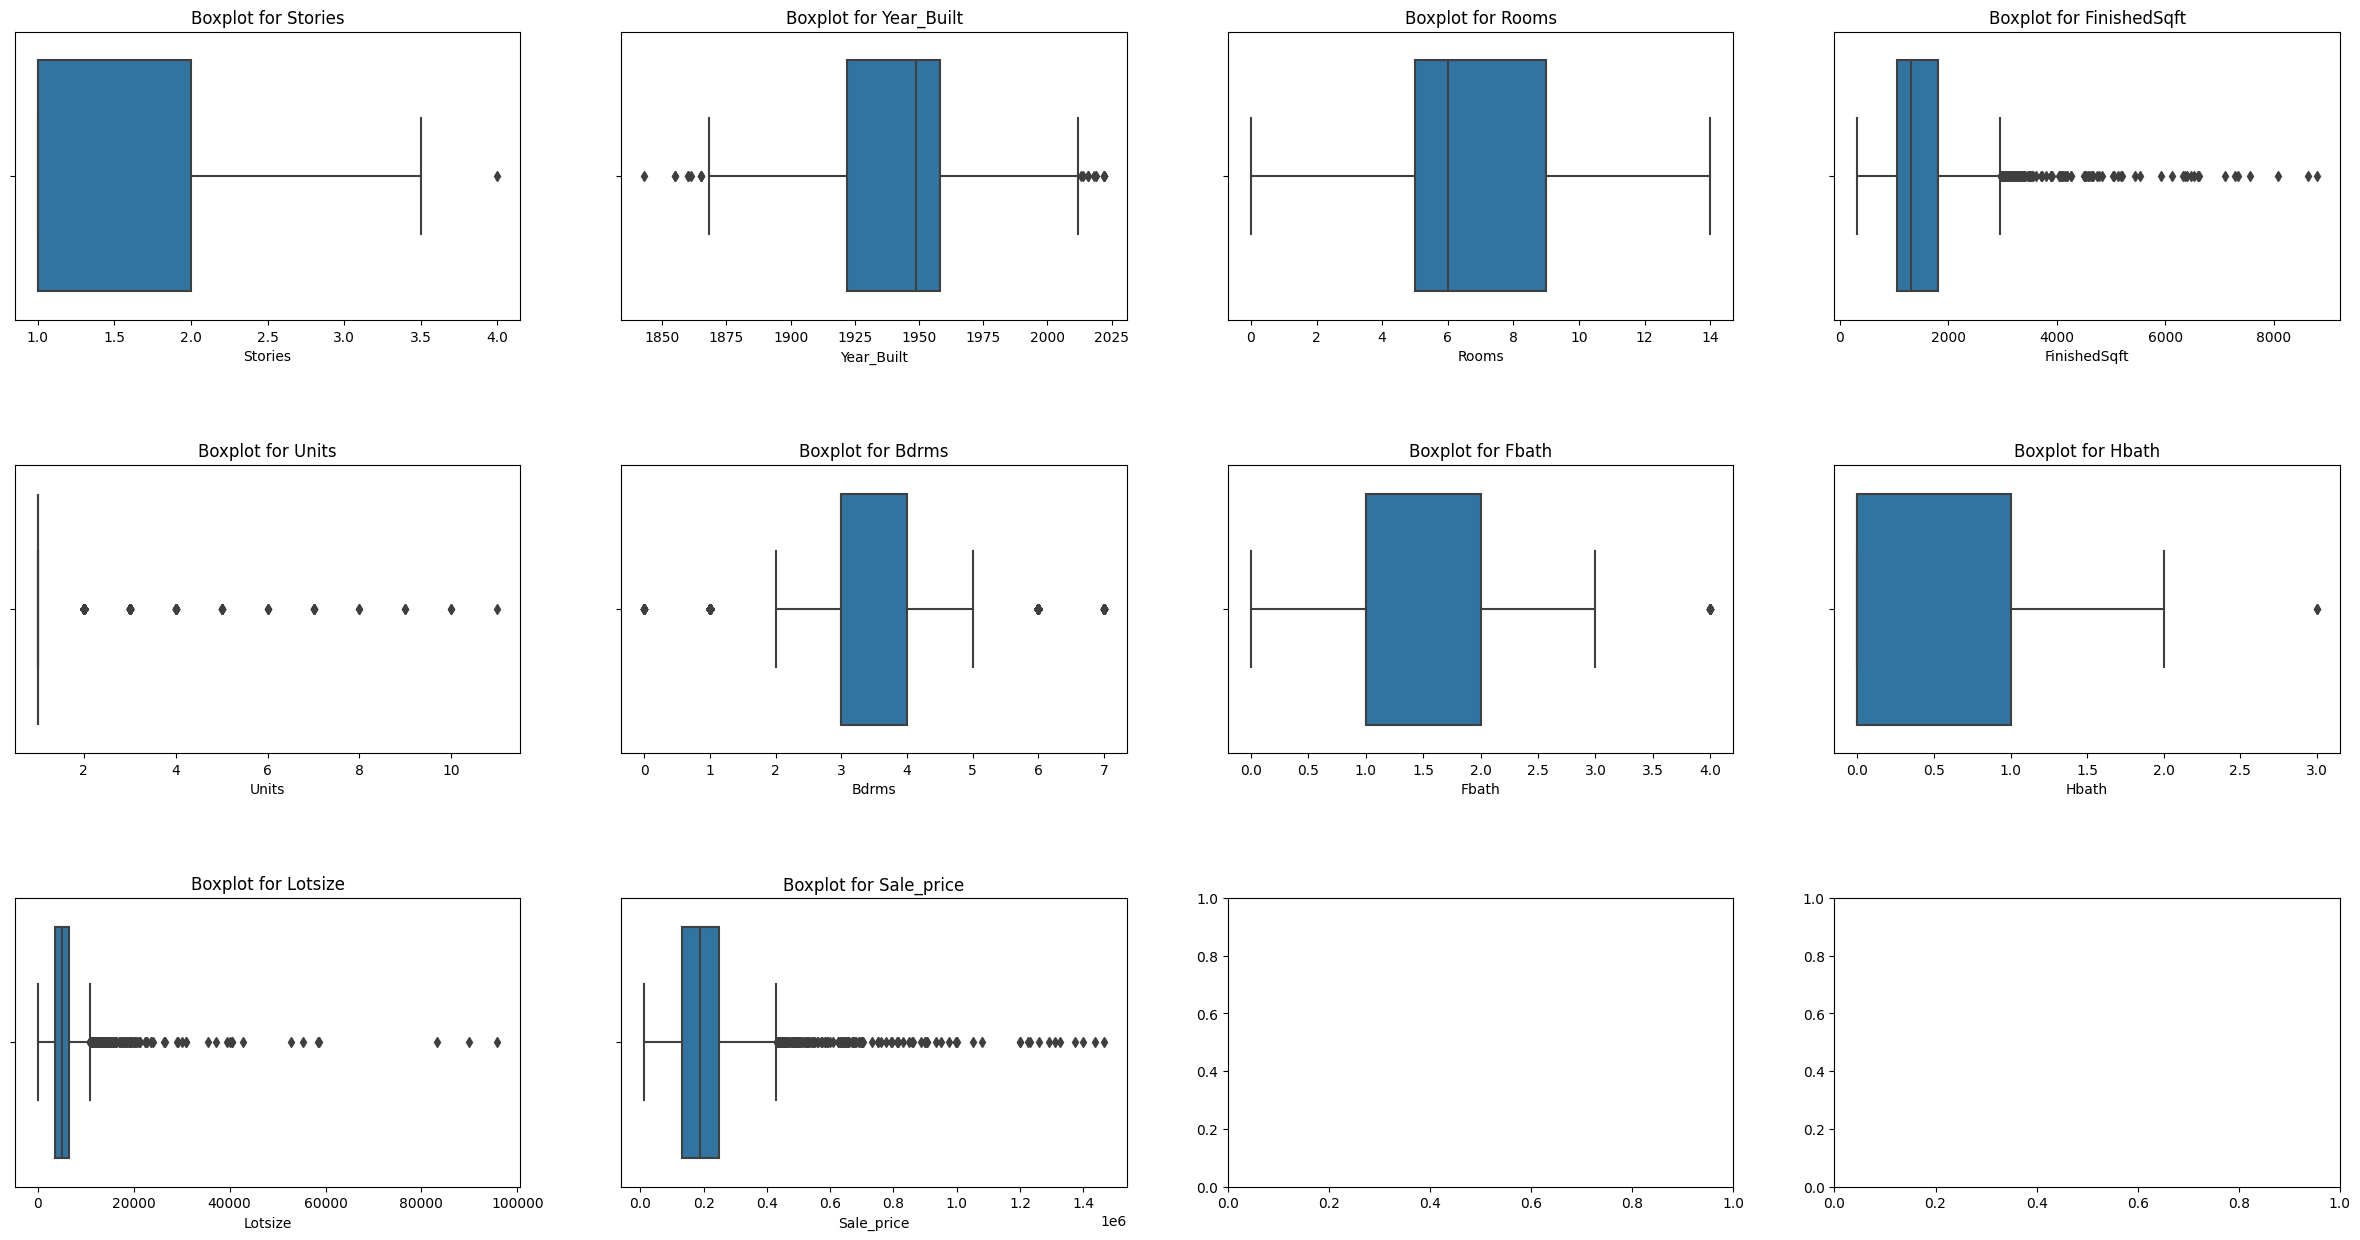

In [241]:
num_cols = df.select_dtypes(exclude=["object"]).columns

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(30, 15))
fig.subplots_adjust(hspace=0.5)

for i, col in enumerate(num_cols):
    sns.boxplot(x=df[col], ax=axes[i // 4, i % 4])
    axes[i // 4, i % 4].set_title(f'Boxplot for {col}')

plt.show()

### Training mit besten Hyperparametern aus 1. Optimierung

In [242]:
pipe = Pipeline(steps=[
    ('preprocessor', prep),
    ('model', GradientBoostingRegressor(random_state=42, max_depth=5, n_estimators=300))
])

y_train = train_data[y].values.ravel()
y_test = test_data[y].values.ravel()

pipe.fit(X=train_data[X], y=y_train)
cv = cross_val_score(estimator=pipe[-1], X=prep.fit_transform(train_data[X]), y=y_train, cv=3, n_jobs=3)

print("Avg. Price on Training", train_data[y].mean().iloc[0])
print("Avg. Price on Test", test_data[y].mean().iloc[0])
print("Cross validation", cv)
print("R2:", pipe.score(X=test_data[X], y=y_test))
print("MAE:", mean_absolute_error(y_true=y_test, y_pred=pipe.predict(test_data[X])))
print("MSE:", mean_squared_error(y_true=y_test, y_pred=pipe.predict(test_data[X])))
print()

Avg. Price on Training 203242.47925060434
Avg. Price on Test 198576.94685990337
Cross validation [0.80087975 0.81864889 0.77339569]
R2: 0.7909652073586254
MAE: 33856.838296264425
MSE: 2648706091.9569244



### Detailliertere Hyperparameter-Optimierung

In [229]:
pipe = Pipeline(steps=[
    ('preprocessor', prep),
    ('model', GradientBoostingRegressor(random_state=42))
])

parameters = {
    'model__max_depth': [None, 5, 10, 15],
    'model__n_estimators': [50, 100, 200, 300, 500],
    'model__learning_rate': [0.01, 0.1, 0.5],
    'model__subsample': [0.5, 0.75, 1.0],
    'model__min_samples_split': [2, 5, 10, 20]
}

grid_search = GridSearchCV(estimator=pipe, param_grid=parameters, cv=3, n_jobs=4)
grid_search.fit(X=train_data[X], y=y_train)

y_train = train_data[y].values.ravel()
y_test = test_data[y].values.ravel()

y_pred = grid_search.predict(test_data[X])

cv = cross_val_score(estimator=grid_search.best_estimator_, X=train_data[X], y=y_train, cv=3, n_jobs=3)

print("Best parameters:", grid_search.best_params_)
print("Cross validation", cv)
print("R2:", grid_search.best_estimator_.score(X=test_data[X], y=y_test))
print("MAE:", mean_absolute_error(y_true=y_test, y_pred=y_pred))
print("MAE:", mean_squared_error(y_true=y_test, y_pred=y_pred))
print()

======  K-nearest Neighbors  ======
Best parameters: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__min_samples_split': 5, 'model__n_estimators': 500, 'model__subsample': 0.5}
Cross validation [0.81524251 0.82738478 0.80995204]
R2: 0.7829217606914192
MAE: 33499.22642102652
MAE: 2750625614.1501055



### Training mit besten Hyperparametern aus 2. Optimierung

In [ ]:
pipe = Pipeline(steps=[
    ('preprocessor', prep),
    ('model', GradientBoostingRegressor(random_state=42, learning_rate=0.1, max_depth=5, min_samples_split=5, n_estimators=500, subsample=0.5))
])

y_train = train_data[y].values.ravel()
y_test = test_data[y].values.ravel()

pipe.fit(X=train_data[X], y=y_train)
cv = cross_val_score(estimator=pipe[-1], X=prep.fit_transform(train_data[X]), y=y_train, cv=3, n_jobs=3)

print("Avg. Price on Training", train_data[y].mean().iloc[0])
print("Avg. Price on Test", test_data[y].mean().iloc[0])
print("Cross validation", cv)
print("R2:", pipe.score(X=test_data[X], y=y_test))
print("MAE:", mean_absolute_error(y_true=y_test, y_pred=pipe.predict(test_data[X])))
print("MSE:", mean_squared_error(y_true=y_test, y_pred=pipe.predict(test_data[X])))
print()